In [15]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from random import random
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt

In [16]:
# Load data
df_laptops_test = pd.read_csv(r"../../data/test.csv", sep=',')
df_laptops_train = pd.read_csv(r"../../data/train.csv", sep=',')

### Cleaning data and solving missing values

In [17]:
# Creating new target variable: 'difference between max and min'
price_difference = (df_laptops_train['max_price'] - df_laptops_train['min_price'])
new_target = pd.DataFrame(price_difference, columns = ['max_min_difference'])
df_laptops_train = pd.concat([df_laptops_train, new_target], axis=1)

In [18]:
# Get all touchscreen values to lower case letters (f.ex: from 'Glossy' --> 'glossy')
def lower_case_screen(df):
    return df['screen_surface'].replace({'Glossy': 'glossy', 'Matte': 'matte'}, inplace=True)

lower_case_screen(df_laptops_train)
lower_case_screen(df_laptops_test)

In [19]:
# Detect missing values
def detect_and_fill_all_missing_values_with_correct_nan(df):
    df.fillna(value=np.nan,inplace=True)

detect_and_fill_all_missing_values_with_correct_nan(df_laptops_train)
detect_and_fill_all_missing_values_with_correct_nan(df_laptops_test)

In [20]:
# Replace NaN screen_surface values with 'glossy' or 'matte' at random
def replace_nan_screen_surface(df):
    for i in range(0,len(df)):
        if type(df.screen_surface[i]) == float:
            if random() >= 0.5:
                df.at[i,'screen_surface'] = 'glossy'
            else:
                df.at[i,'screen_surface'] = 'matte'

replace_nan_screen_surface(df_laptops_train)
replace_nan_screen_surface(df_laptops_test)

In [21]:
# Replace weight missing values by the median of all the weights
def replace_weight_nans_with_median(df):
    df['weight'] = df['weight'].fillna(value=df['weight'].median())

replace_weight_nans_with_median(df_laptops_train)
replace_weight_nans_with_median(df_laptops_test)

In [22]:
# Replace missing OS and OS_details based on brand
def replace_missing_os_and_os_details(df):
    for i in range(0,len(df)):
        if type(df.os[i]) == float:        # When the value is missing
            if 'apple' in df.brand[i].lower():
                df.at[i,'os_details'] = 'macOS Catalina'
                df.at[i,'os'] = 'macOS'
            else:
                df.at[i,'os_details'] = 'Windows'
                df.at[i,'os'] = 'Windows 10'
                
replace_missing_os_and_os_details(df_laptops_train)
replace_missing_os_and_os_details(df_laptops_test)

In [23]:
def resolve_last_missing_values(df):
    # Make index and column arrays to then use in the creation of the new df
    index_array = np.array(range(0,len(df)))
    column_names_array = np.array(list(df.columns), dtype=object)
    
    # replace rest of missing values with most frequent simple imputer
    imp = SimpleImputer(strategy="most_frequent")
    temp_array = imp.fit_transform(df)

    no_nulls_df = pd.DataFrame(data=temp_array[0:,0:],index=index_array, columns=column_names_array)
    
    return no_nulls_df

In [24]:
no_nulls_train = resolve_last_missing_values(df_laptops_train)
no_nulls_test = resolve_last_missing_values(df_laptops_test)

In [25]:
# Remove unimportant columns
def remove_unimportant_columns(df):
    return df.drop(columns = ['id',
                              'name',         # Name information is to be found in other columns
                              'base_name',    # Base name is partially in brand
                              'os',           # OS_details is more important
                              'discrete_gpu', # Information contained in GPU information
                              'cpu_details',  # Only CPU column is good
                              'pixels_y']) 

train_df = remove_unimportant_columns(no_nulls_train)
test_df = remove_unimportant_columns(no_nulls_test)

#### It's here that I added the extra data:

In [19]:
# Duplicate high price laptops (>2000)
temp_df = train_df[train_df.max_price > 2000]
extra_data = [train_df]
for temp in [temp_df]*9:
    extra_data.append(temp)

In [20]:
# train_df = pd.concat(extra_data, ignore_index=True)

## Feature engineering and feature selection

In [26]:
# Encode glossy and matte as 1 and 0 respectively
def dummy_encode_screen_surface(df):
    for i in range(0,len(df)):
        if df.screen_surface[i] == 'glossy':
            df.at[i,'screen_surface'] = 1
        else:
            df.at[i,'screen_surface'] = 0

dummy_encode_screen_surface(train_df)
dummy_encode_screen_surface(test_df)

In [29]:
def divide_data_cat_and_num(df):
    # For the training set
    if 'min_price' in df.columns:
        df_num = df[['screen_size', 
                     'pixels_x', 
                     'screen_surface', 
                     'touchscreen', 
                     'detachable_keyboard', 
                     'ram', 
                     'ssd',
                     'storage',
                     'weight',
                     'min_price',
                     'max_price', 
                     #'max_min_difference'
                    ]].astype('int')
    # For the test set
    else:
        df_num = df[['screen_size', 
                     'pixels_x', 
                     'screen_surface', 
                     'touchscreen', 
                     'detachable_keyboard', 
                     'ram', 
                     'ssd',
                     'storage',
                     'weight'
                     ]].astype('int')

    df_cat = df[['brand',
                 #'cpu', 
                 #'os_details',
                 'gpu'
                ]]
    return df_num, df_cat

train_num, train_cat = divide_data_cat_and_num(train_df)
test_num, test_cat = divide_data_cat_and_num(test_df)

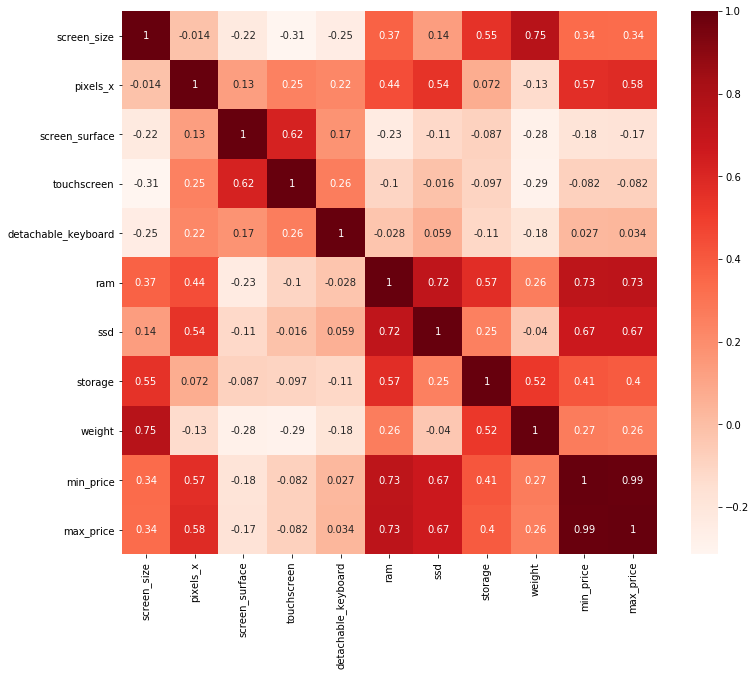

In [30]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = train_num.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [25]:
#Correlation with output variable
cor_target = abs(cor[['min_price', 'max_price', 'max_min_difference']])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

,min_price,max_price,max_min_difference
screen_size,NaN,NaN,NaN
pixels_x,0.517958,0.537678,NaN
screen_surface,NaN,NaN,NaN
touchscreen,NaN,NaN,NaN
detachable_keyboard,NaN,NaN,NaN
ram,0.633834,0.624357,NaN
ssd,0.639904,0.634462,NaN
storage,NaN,NaN,NaN
weight,NaN,NaN,NaN
min_price,1.000000,0.993215,NaN


In [26]:
# Keep only features that aren't correlated with eachother
print(train_num[['pixels_x','ram']].corr())
print(train_num[['pixels_x','ssd']].corr())
print(train_num[['ram','ssd']].corr())

# --> so only use pixels_x and ram

          pixels_x       ram
pixels_x  1.000000  0.512838
ram       0.512838  1.000000
          pixels_x       ssd
pixels_x  1.000000  0.644952
ssd       0.644952  1.000000
         ram      ssd
ram  1.00000  0.79815
ssd  0.79815  1.00000


In [27]:
# Only keep relevant features
train_num = train_num[['ram', 'pixels_x', 'screen_size', 'storage', 'min_price', 'max_price', 'max_min_difference']]
test_num = test_num[['ram', 'pixels_x', 'screen_size', 'storage']]

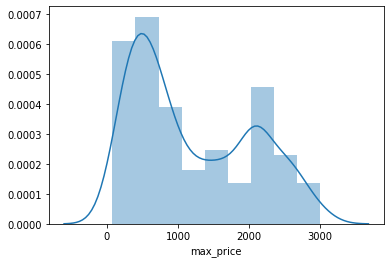

In [28]:
x = train_num['max_price']
# x2 = train_num['pixels_x']
sns.distplot(x);

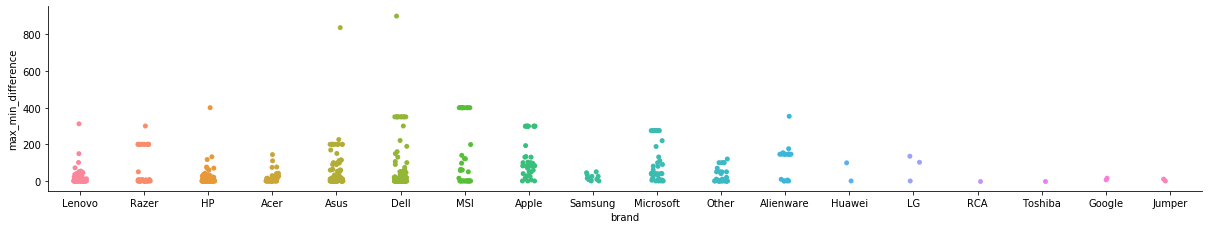

In [29]:
# It seems as if max_min_prices of more than 400 seem outliers
temp_df_train = pd.concat([train_cat,train_num], axis=1)

figure = sns.catplot(x='brand', y='max_min_difference', data=temp_df_train);

figure.fig.set_figwidth(20)
figure.fig.set_figheight(3)

In [30]:
# Remove all instances with a min_max_difference of more than 400
temp_df_train = temp_df_train.drop(temp_df_train[temp_df_train.max_min_difference > 400].index)

# Reassign the cat and num variables to the correct dataframes
train_cat = temp_df_train[train_cat.columns]
train_num = temp_df_train[train_num.columns]

In [31]:
# One-hot encode all categorical variables
def one_hot_encode(df_train_categories, df_test_categories):
    full_enc = OneHotEncoder(handle_unknown='ignore')
    full_enc.fit(df_train_categories.to_numpy())
    
    full_transform_train = full_enc.transform(df_train_categories.to_numpy()).toarray()
    full_transform_test = full_enc.transform(df_test_categories.to_numpy()).toarray()
    
    full_transform_train_df = pd.DataFrame(full_transform_train, columns = full_enc.get_feature_names())
    full_transform_test_df = pd.DataFrame(full_transform_test, columns = full_enc.get_feature_names())
    
    return full_transform_train_df, full_transform_test_df

train_cat_ohe, test_cat_ohe = one_hot_encode(train_cat, test_cat)

In [32]:
train_num = train_num.drop('max_min_difference', axis=1)

In [33]:
train_num

,ram,pixels_x,screen_size,storage,min_price,max_price
0,8,1920,15,1000,899,899
1,16,1920,15,512,2099,2099
2,8,1366,15,500,439,449
3,6,1920,15,1000,375,449
4,8,1600,17,1000,559,559
...,...,...,...,...,...,...
667,16,1920,15,1128,2499,2499
668,16,3840,15,1000,1749,2099
669,16,1920,15,512,2099,2099
670,32,1920,17,1000,2149,2149


In [34]:
# Normalize all numerical variables
def normalize(train_num, test_num):
    
    train_num_inputs = train_num[train_num.columns[:-2]]
    train_targets = train_num[train_num.columns[-2:]]
    test_num_inputs = test_num
    
    # Fit one min_max scaler for numerical inputs and one for targets
    min_max_scaler_inputs = preprocessing.MinMaxScaler()
    min_max_scaler_inputs.fit(train_num_inputs.values)
    train_scaled = min_max_scaler_inputs.transform(train_num_inputs.values)
    test_scaled = min_max_scaler_inputs.transform(test_num_inputs.values)
    
    min_max_scaler_targets = preprocessing.MinMaxScaler()
    targets_scaled = min_max_scaler_targets.fit_transform(train_targets.values)
    
    # Max and min prices invidivually
    max_scaler_targets = preprocessing.MinMaxScaler()
    min_scaler_targets = preprocessing.MinMaxScaler()
    max_scaler_targets.fit(train_targets['max_price'].values.reshape(-1, 1))
    min_scaler_targets.fit(train_targets['min_price'].values.reshape(-1, 1))
    targets_max_scaled = max_scaler_targets.transform(train_targets['max_price'].values.reshape(-1, 1))
    targets_min_scaled = min_scaler_targets.transform(train_targets['min_price'].values.reshape(-1, 1))
    
    # Make final dataframes
    train_norm = pd.DataFrame(train_scaled, columns = train_num_inputs.columns)
    test_norm = pd.DataFrame(test_scaled, columns = test_num_inputs.columns)
    target_norm = pd.DataFrame(targets_scaled, columns = train_targets.columns)
    
    targets_max = pd.DataFrame(targets_max_scaled, columns = ['max_price'])
    targets_min = pd.DataFrame(targets_min_scaled, columns = ['min_price'])
    
    
    return train_norm, target_norm, test_norm, min_max_scaler_targets, targets_max, targets_min, max_scaler_targets, min_scaler_targets

train_norm, target_norm, test_norm, min_max_scaler_targets, targets_max_norm, targets_min_norm, max_scaler_targets, min_scaler_targets = normalize(train_num,test_num)

In [35]:
# Check distributions of train and test set numerical data
# sns.distplot(test_norm['pixels_x']);
# sns.distplot(train_norm['pixels_x']);

In [36]:
# Bring normalized and one-hot-encoded data together
final_df_train = pd.concat([train_norm, train_cat_ohe, target_norm], axis=1)
final_df_test = pd.concat([test_norm, test_cat_ohe], axis=1)

In [37]:
final_df_train

,ram,pixels_x,screen_size,storage,x0_Acer,x0_Alienware,x0_Apple,x0_Asus,x0_Dell,x0_Google,...,x1_NVIDIA GeForce MX250,x1_NVIDIA GeForce RTX 2060,x1_NVIDIA GeForce RTX 2070,x1_NVIDIA GeForce RTX 2070 Max-Q,x1_NVIDIA GeForce RTX 2080,x1_NVIDIA GeForce RTX 2080 Max-Q,x1_NVIDIA Quadro M1000M,x1_PowerVR GX6250,min_price,max_price
0,0.096774,0.250000,0.714286,0.246988,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283276,0.281560
1,0.225806,0.250000,0.714286,0.124498,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.692833,0.692097
2,0.096774,0.033594,0.714286,0.121486,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126280,0.127609
3,0.064516,0.250000,0.714286,0.246988,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104437,0.127609
4,0.096774,0.125000,1.000000,0.246988,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167235,0.165241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,0.225806,0.250000,0.714286,0.279116,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.829352,0.828943
666,0.225806,1.000000,0.714286,0.246988,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573379,0.692097
667,0.225806,0.250000,0.714286,0.124498,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.692833,0.692097
668,0.483871,0.250000,1.000000,0.246988,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.709898,0.709203
